# Titanic: Machine Learning from Disaster


## Contents of the Notebook

### Part1 : Introduction
### Part2 : Load and check data
    1) load data

    2) Outlier detection

    3) joining train and test set

    4) check for null and missing values
### Part3 : Feature analysis
    1) Numerical values

    2) Categorical values
### Part4 : Filling missing Values
    1) Age

### Part5 : Feature engineering
    1) Name/Title

    2) Family Size

    3) Cabin

    4) Ticket
### Part6 : Modeling
    

## 1. Introduction

I choosed the Titanic competition which is a good way to introduce feature engineering and ensemble modeling. 

This script follows three main parts:

* **Feature analysis**
* **Feature engineering**
* **Modeling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from collections import Counter
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data
### 2.1 Load data

In [2]:
# Load train and Test set
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
IDtest = test["PassengerId"]       

In [3]:
# Check the data set
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (891, 12)
Test  data :  (418, 11)


In [4]:
# Check the train data set's columns
print("Train data columns Qty :", len(train.columns), "\n\n")
print("Train data columns :", train.columns)

Train data columns Qty : 12 


Train data columns : Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
# states of train data set
# describe the train
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# states of train data set
# describe the data by dtype

summary_train = pd.DataFrame()
for col in train.columns:
    
    # column's name
    column_name = col
    
    # check column's type
    dtype = train[column_name].dtype
    
    # check the qty of not null data per each column
    actual_value_qty = len(train.loc[train[column_name].notnull()])
 
    # length of each columns
    rows = len(train[column_name])
    
    # percent of not null values per columns
    actual_value_percent = round((actual_value_qty / rows)*100,1)
    
    # count the unique values per columns
    unique_values = len(train[column_name].unique())
    
    # sum up the null values per columns
    null_qty = train[column_name].isnull().sum()
    
    # make the dataframe
    data = {'column_name' : column_name, 'dtype' : dtype, 'actual_value_qty' : actual_value_qty,'null_qty' : null_qty, \
            'actual_value_percent(%)' : actual_value_percent  ,'unique_values_qty' : unique_values}
    
    summary_train = summary_train.append(data, ignore_index = True)
    

summary_train.pivot_table(index = ['dtype', 'column_name'])

actual_value_percent(%)  actual_value_qty  null_qty  \
dtype   column_name                                                        
int64   Parch                          100.0             891.0       0.0   
        PassengerId                    100.0             891.0       0.0   
        Pclass                         100.0             891.0       0.0   
        SibSp                          100.0             891.0       0.0   
        Survived                       100.0             891.0       0.0   
float64 Age                             80.1             714.0     177.0   
        Fare                           100.0             891.0       0.0   
object  Cabin                           22.9             204.0     687.0   
        Embarked                        99.8             889.0       2.0   
        Name                           100.0             891.0       0.0   
        Sex                            100.0             891.0       0.0   
        Ticket                         100.0             891.0       0.0   

                     unique_values_qty  
dtype   column_name                     
int64   Parch                      7.0  
        PassengerId              891.0  
        Pclass                     3.0  
        SibSp                      7.0  
        Survived                   2.0  
float64 Age                       89.0  
        Fare                     248.0  
object  Cabin                    148.0  
        Embarked                   4.0  
        Name                     891.0  
        Sex                        2.0  
        Ticket                   681.0

Comments :

    - Age, Cabin and Embarked on train data have some missing values. Escpecially, Cabin columns have lot of missing values

### 2-2 Analysis the univaiance

    1) Seperate Numerical feature and Categorical feature 

In [7]:
# Since Pclass is Categorical feature, I am going to convet it to string in both train and test set
train["Pclass"] = train["Pclass"].astype("str")
test["Pclass"] = test["Pclass"].astype("str")

In [8]:
numerical_features = []
categorical_features = []
for f in train.columns:
    if train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [9]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

Numerical Features Qty : 6 

Numerical Features :  ['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare'] 


Categorical Features Qty : 6 

Categorical Features : ['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


### 2.3 Outlier detection

    1) By box-and-whisker's IQR   
    
         - The Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised
         between the 1st and 3rd quartile of the distribution values (IQR).

In [10]:
# Outlier detection by Box plot 

def detect_outliers(data, features):
    
    outlier_indices = []
    # iterate over features(columns)
    for feature in features:
        # 1st quartile (25%)
        Q1 = np.percentile(data[feature], 25)
         # 3rd quartile (75%)
        Q3 = np.percentile(data[feature], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
         # outlier step
        outlier_step = 1.5 * IQR
        
        # determine a list of indices of outliers for feature col
        outliers = data[(data[feature] < Q1 - outlier_step) | (data[feature] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outliers)
        
    outlier_indices = Counter(outlier_indices)
    outliers = list( num for num, qty in outlier_indices.items() if qty > 2 )
        
    return outliers   

Note : I decided to detect outliers from the numerical values features (Age, SibSp, Sarch and Fare)

In [11]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_numerical_features = detect_outliers(train,["Age", "SibSp","Parch", "Fare"])


In [12]:
train.loc[Outliers_numerical_features]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Comments : 

    - Found 10 outliers and I am going to remove it

In [13]:
# drop outliers
train = train.drop(Outliers_numerical_features, axis = 0).reset_index(drop=True)

### 2.4 Handle missing data

    1) join the train and test set

In [14]:
# in order to handle all missing data 
train_len = len(train)
all_data =  pd.concat([train, test], axis=0).reset_index(drop=True)

    2) check for null and missing value

In [15]:
# Fill empty and NaNs values with NaN
all_data = all_data.fillna(np.nan)

# Copy all_data
all_data_cp = all_data.copy()

# check for null values
all_data_null = all_data_cp.isnull().sum()
all_data_null = all_data_null.drop(all_data_null[all_data_null == 0].index).sort_values(ascending=False)

# drop the null values of Survived because Survived missing values correspond to the join testing dataset
del all_data_null['Survived']

Missing Data Features's Qty :  [4]
Total Missing Data's Qty :  [1266]


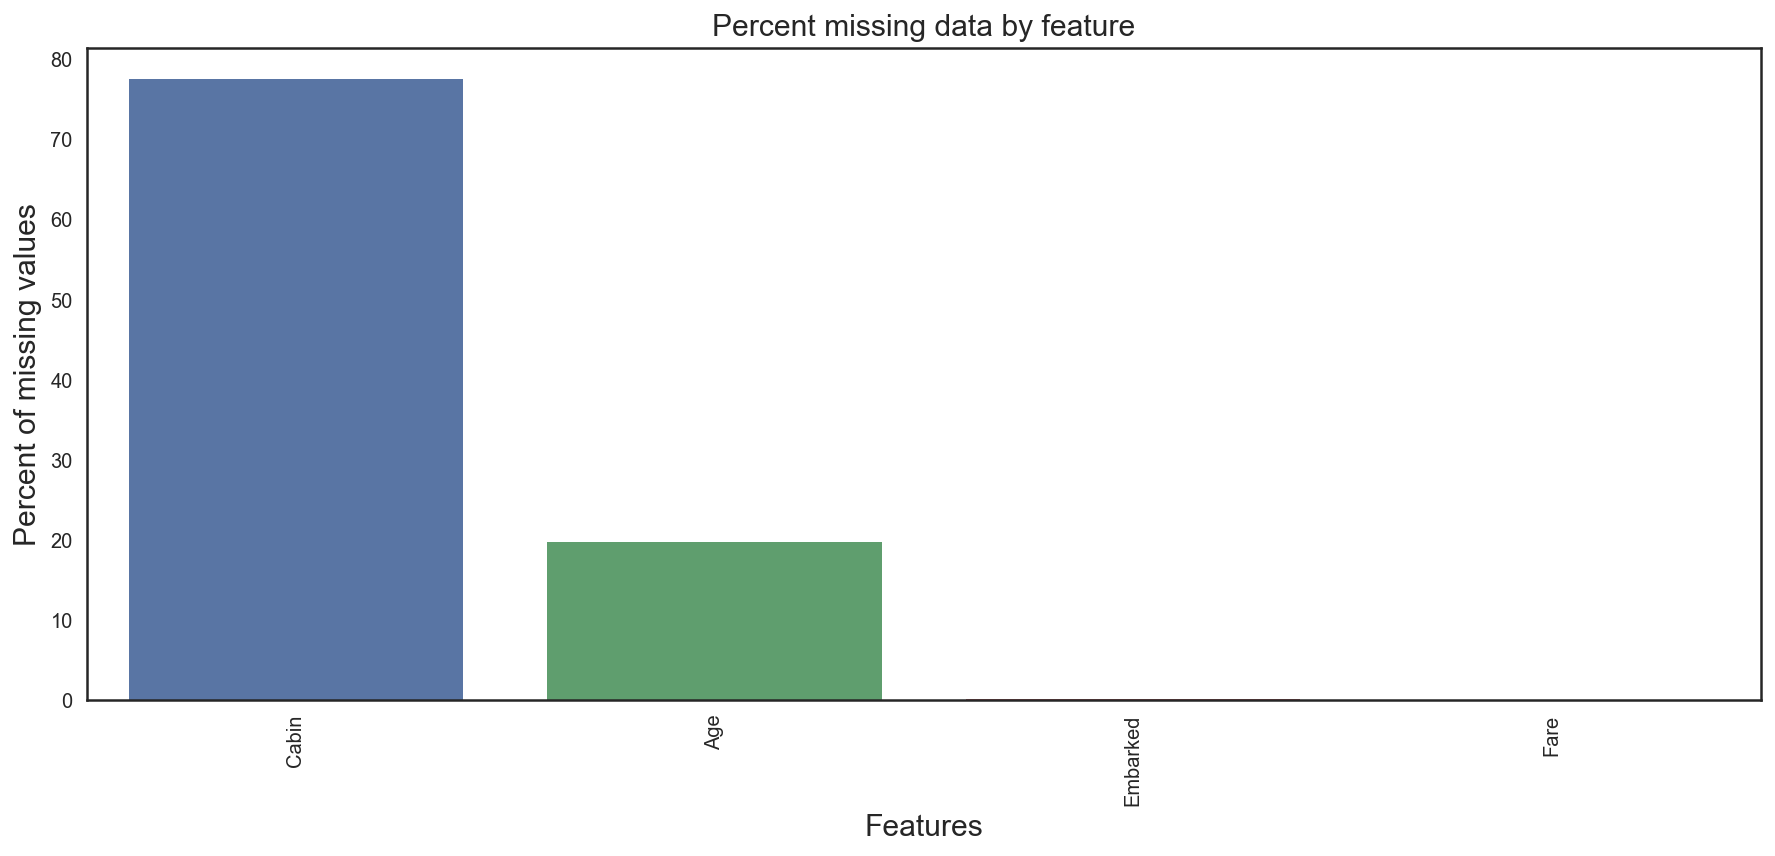

In [16]:
# make missing dataframe
all_data_missing = pd.DataFrame({'Missing Numbers' :all_data_null})
all_data_null =  all_data_null / len(all_data_cp)*100

# draw the graph for missing data 
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_null.index, y=all_data_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print("Missing Data Features's Qty : " , all_data_missing.count().values)
print("Total Missing Data's Qty : " , all_data_missing.sum().values)

Comments : 

    - Age and Cabin features have an important part of missing values.

## 3. Feature analysis
### 3.1 Numerical values

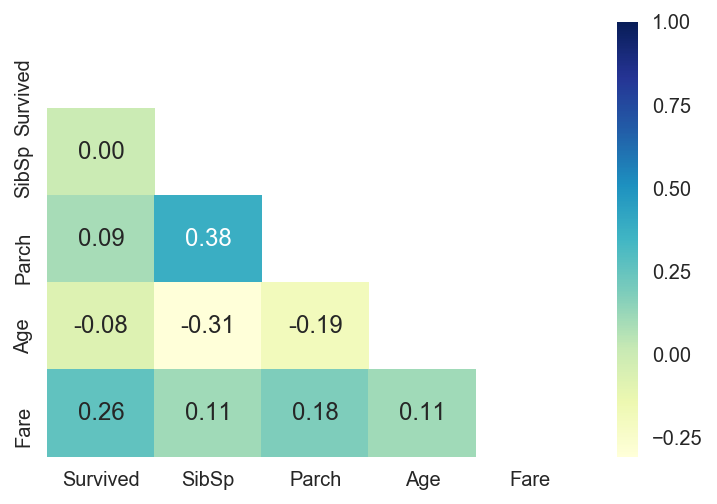

In [17]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
ls_numeric = ["Survived","SibSp","Parch","Age","Fare"]
corr = train[ls_numeric].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

Comments :

    - Only Fare feature seems to have a significative correlation with the survival probability.

    - It doesn't mean that the other features are not usefull. Subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features

#### SibSP

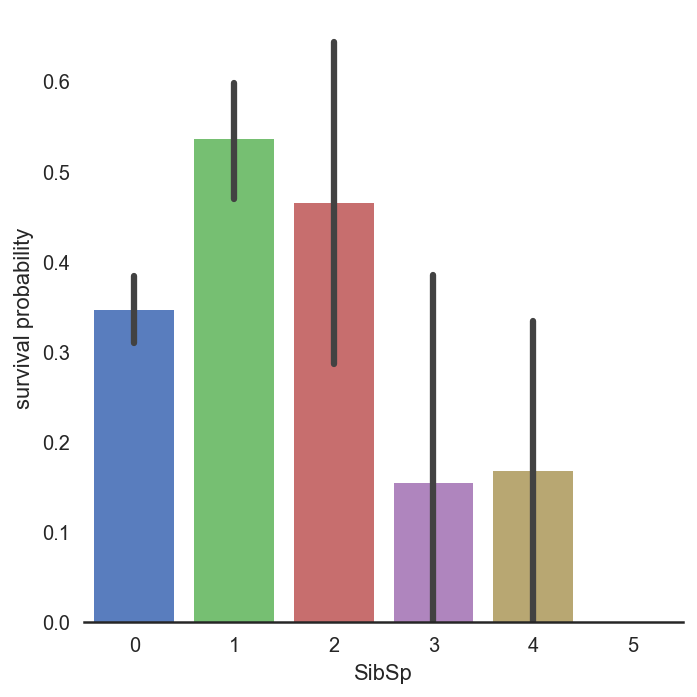

In [18]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Comments :

    - It seems that passengers having a lot of siblings/spouses have less chance to survive

    - Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

#### Parch

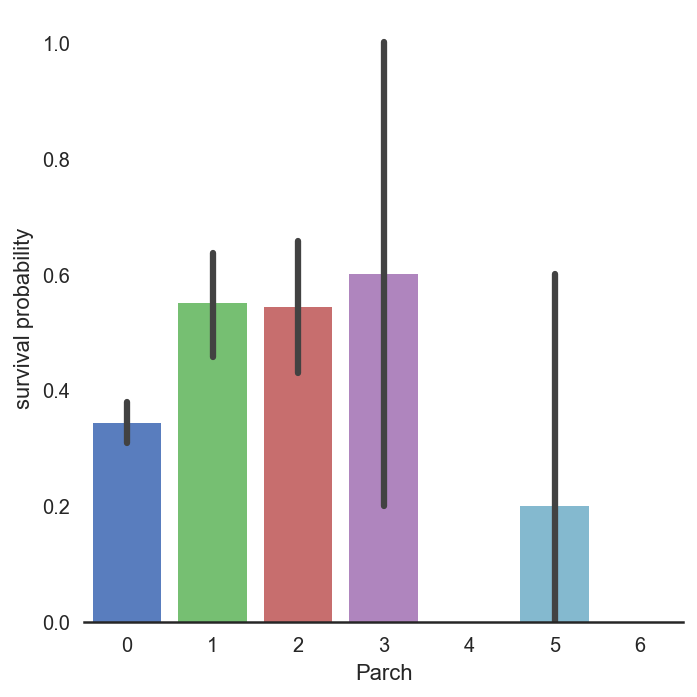

In [19]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Comments :

    - Couple and small families have more chance to survive, more than single (Parch 0),and large families (Parch 5,6 )

#### Age

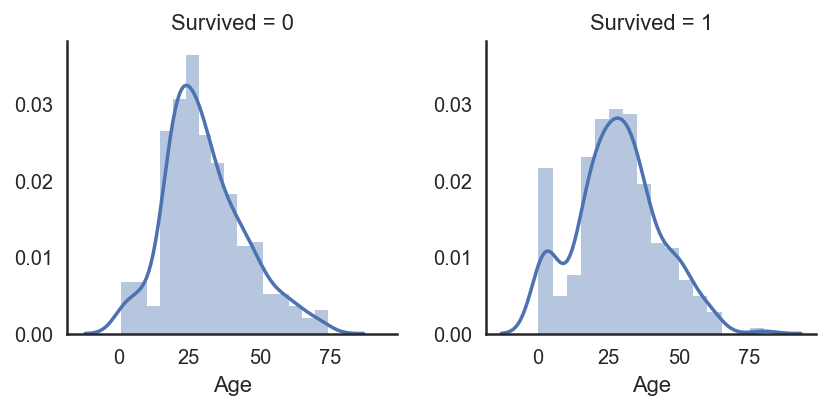

In [20]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Comments :

    - Age distribution seems to be a tailed distribution, maybe a gaussian distribution.

    - Notice that age distributions are not the same in the survived and not survived subpopulations.
    
    - There is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived. So it seems that very young passengers have more chance to survive.

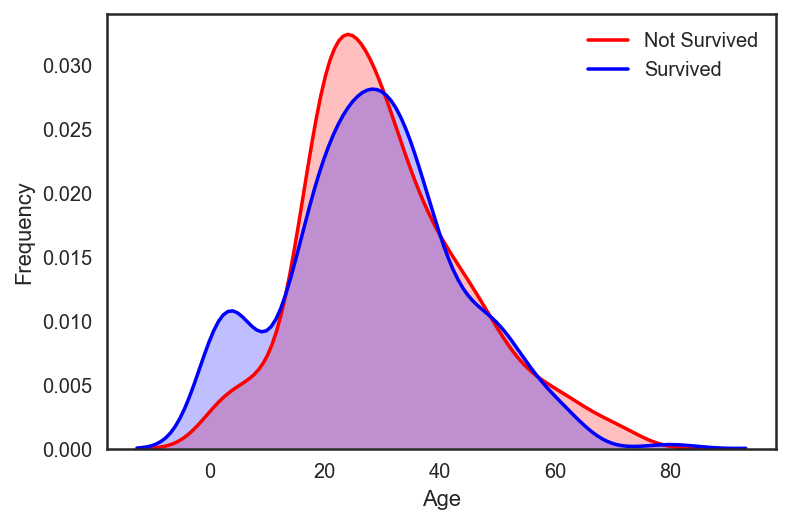

In [21]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

Comments : 

    - When we superimpose the two densities , we cleary see a peak correponsing (between 0 and 10) to babies and young childrens.

#### Fare

In [22]:
# check how many missing values on Fare
all_data["Fare"].isnull().sum()

1

In [23]:
#Fill Fare missing values with the median value
all_data["Fare"] = all_data["Fare"].fillna(all_data["Fare"].median())

Comments :

    - Since we have one missing value , i decided to fill it with the median value which will not have an important effect on the prediction.

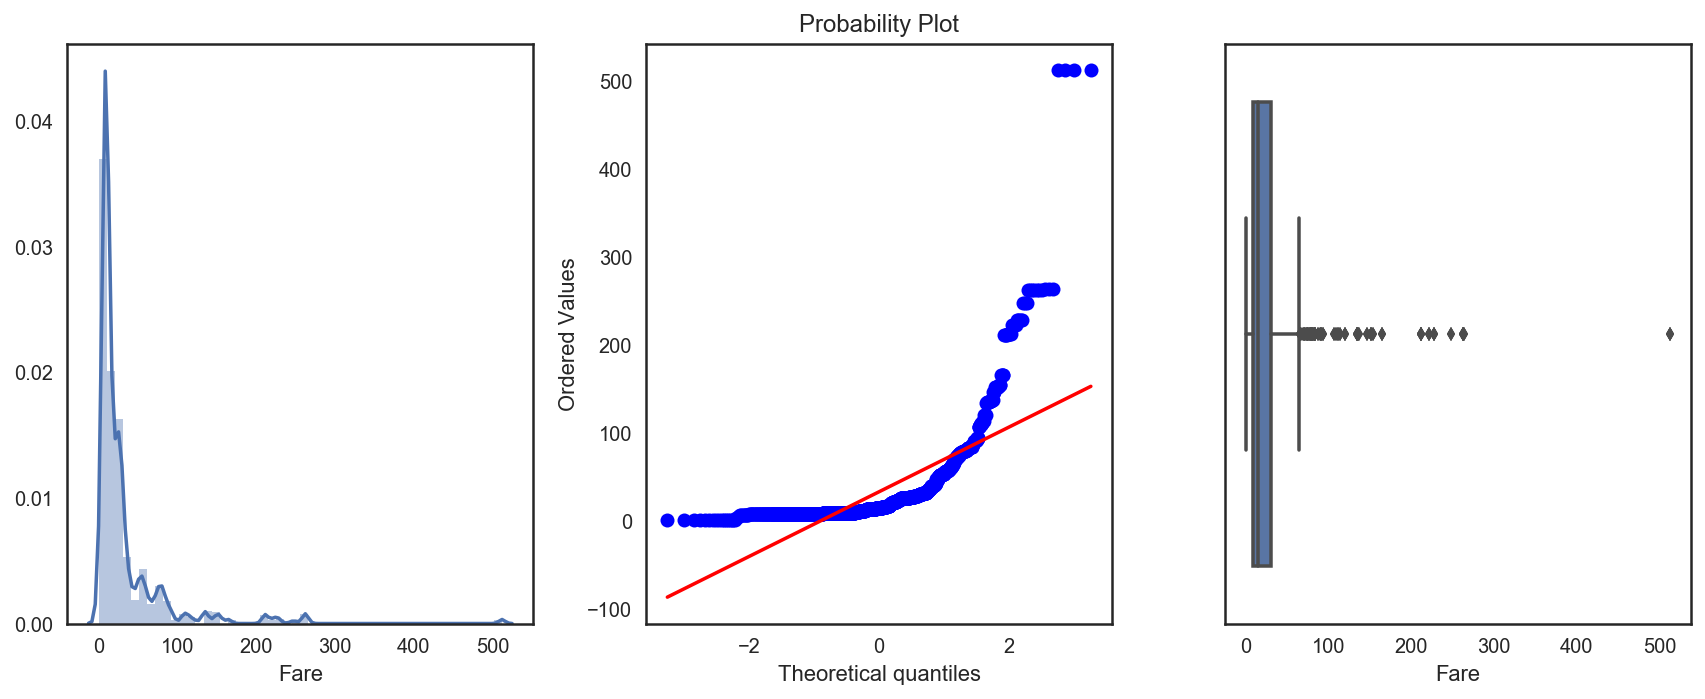

Skewness: 4.511862
Kurtosis: 29.183273


In [24]:
# Explore Fare distribution 
plt.figure(figsize=(12,5))

plt.subplot(131)
sns.distplot(all_data["Fare"])

plt.subplot(132)
stats.probplot(all_data["Fare"], plot=plt)

plt.subplot(133)
sns.boxplot(all_data["Fare"])
plt.tight_layout()
plt.show()

print("Skewness: %f" % all_data['Fare'].skew())
print("Kurtosis: %f" % all_data['Fare'].kurt())

Comments : 

    - As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled. 

    - In this case, it is better to transform it with the log function to reduce this skew. 

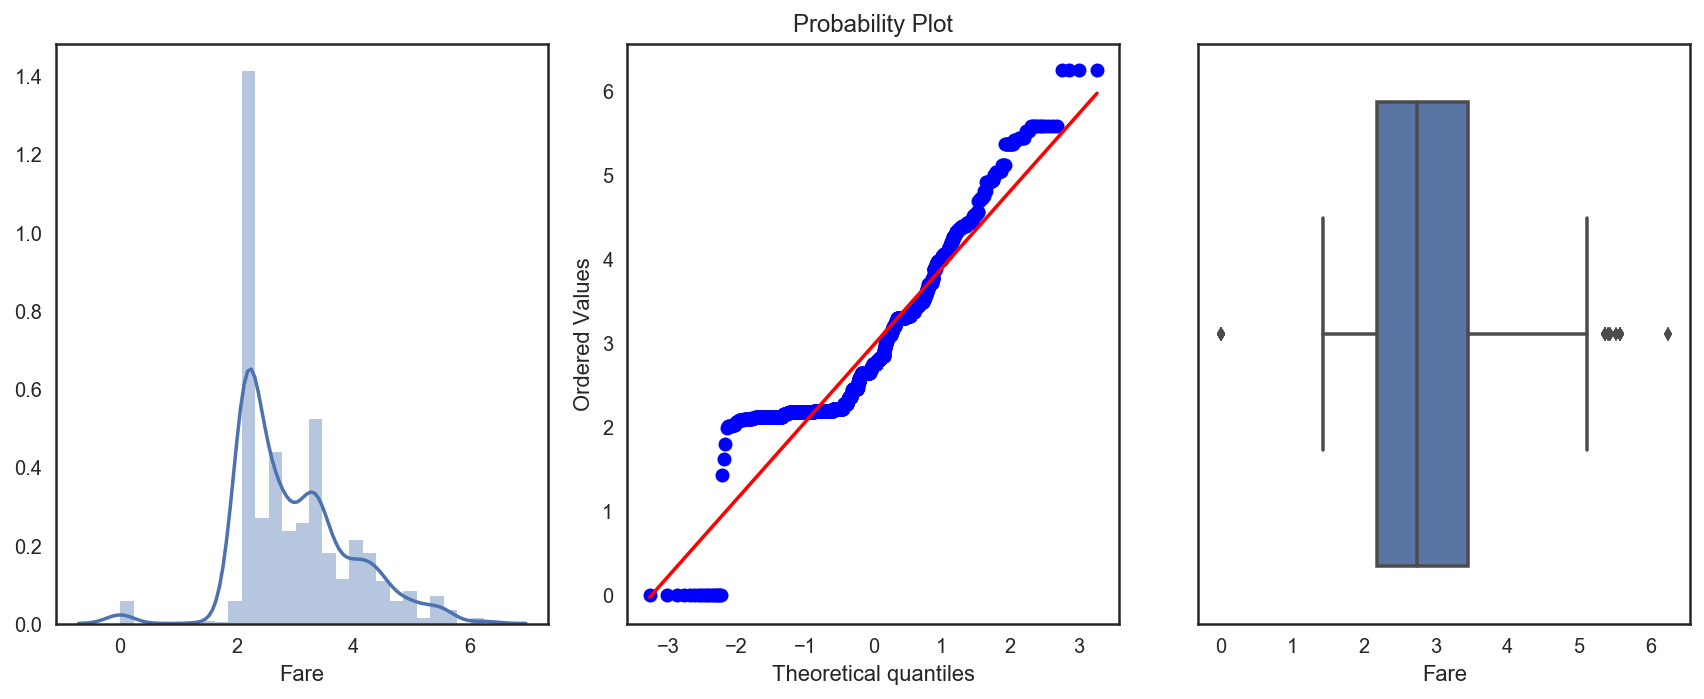

Skewness: 0.544004
Kurtosis: 0.921062


In [25]:
all_data["Fare"] = np.log1p(all_data["Fare"])

# Explore Fare distribution 
plt.figure(figsize=(12,5))

plt.subplot(131)
sns.distplot(all_data["Fare"])

plt.subplot(132)
stats.probplot(all_data["Fare"], plot=plt)

plt.subplot(133)
sns.boxplot(all_data["Fare"])
plt.tight_layout()
plt.show()

print("Skewness: %f" % all_data['Fare'].skew())
print("Kurtosis: %f" % all_data['Fare'].kurt())

Comments : 

    - Skewness is clearly reduced after the log transformation

### 3.2 Categorical values
#### Sex

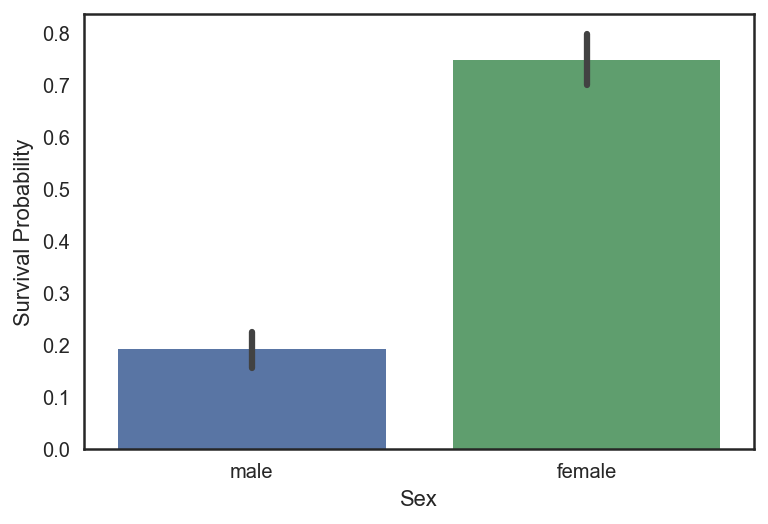

In [26]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

Comments :

    - It is clearly obvious that Male have less chance to survive than Female.

    - Sex, might play an important role in the prediction of the survival.

#### Pclass

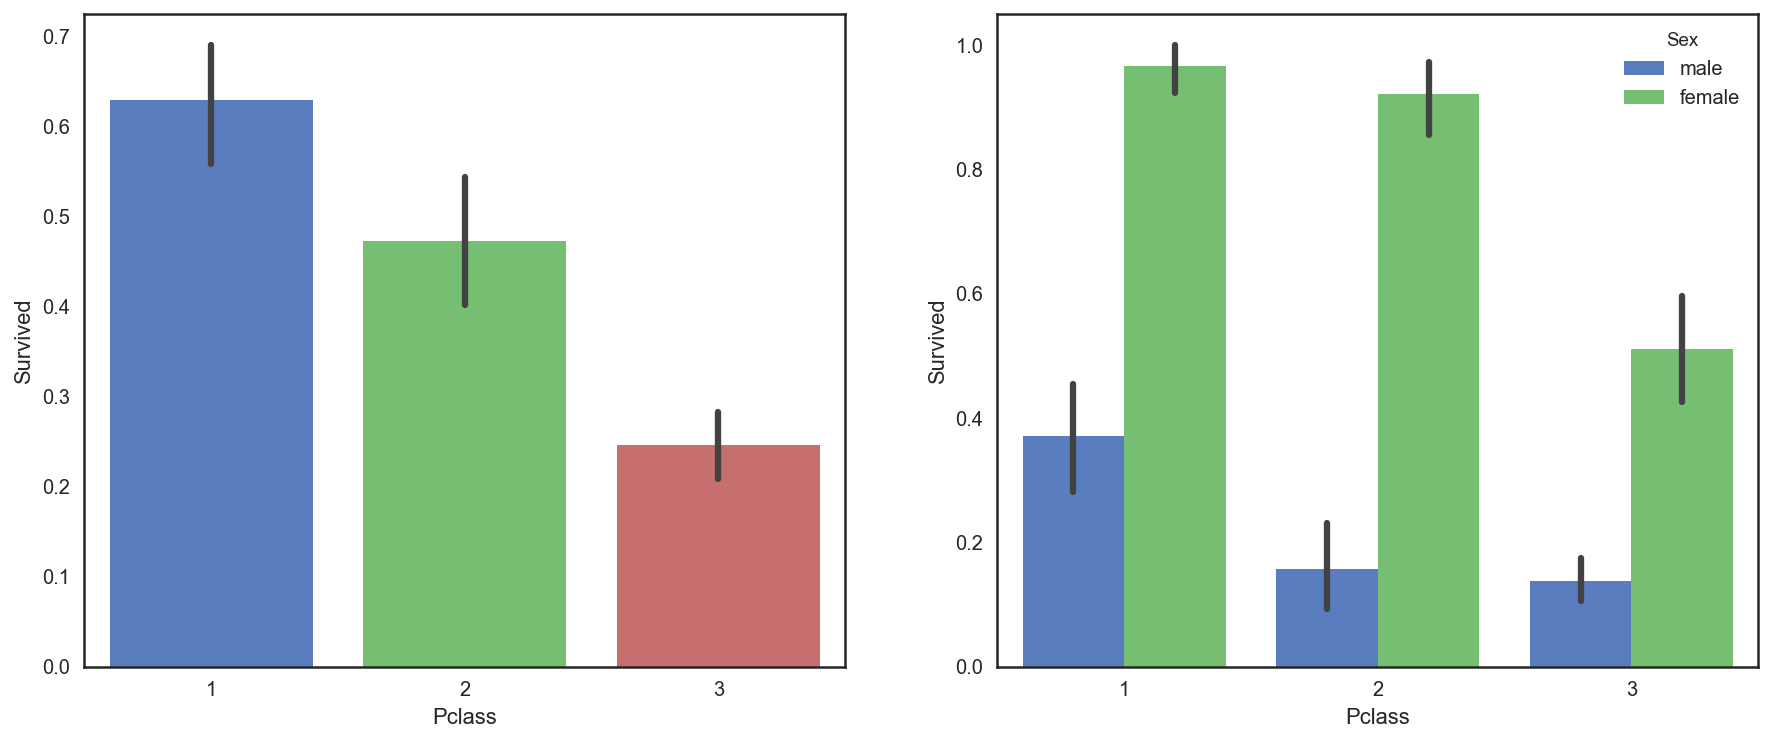

In [27]:
# Explore Pclass vs Survived
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
sns.barplot(x="Pclass",y="Survived",data=train, palette = "muted", ax=ax1)


# Explore Pclass vs Survived by Sex
ax2 = plt.subplot(1,2,2)
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train, palette="muted", ax=ax2)

plt.show()

Comments :

    - The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.

#### Embarked

In [28]:
all_data["Embarked"].isnull().sum()

2

Note : Since we have two missing value , I decided to fill it with the most fequent value of "Embarked"(S)

In [29]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
all_data["Embarked"] = all_data["Embarked"].fillna("S")

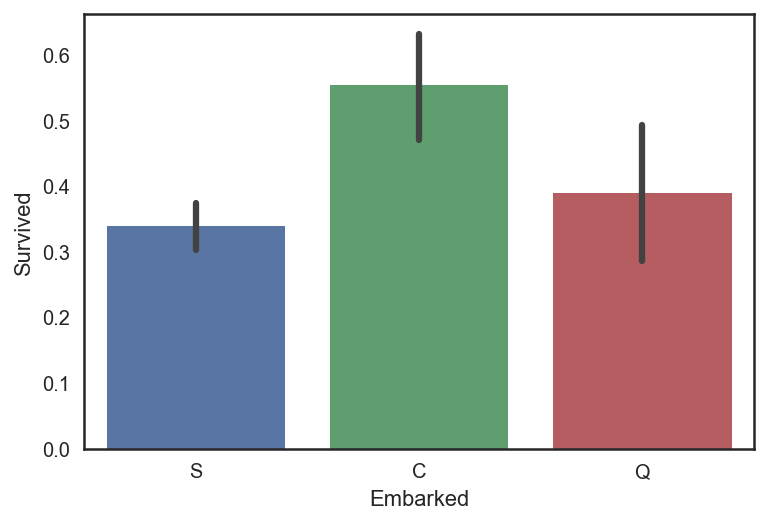

In [30]:
# Explore Embarked vs Survived 
g = sns.barplot(x="Embarked", y="Survived",  data=train)

Comments :

    - It seems that passenger coming from Cherbourg (C) have more chance to survive.

    - My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).

    - Let's see the Pclass distribution vs Embarked

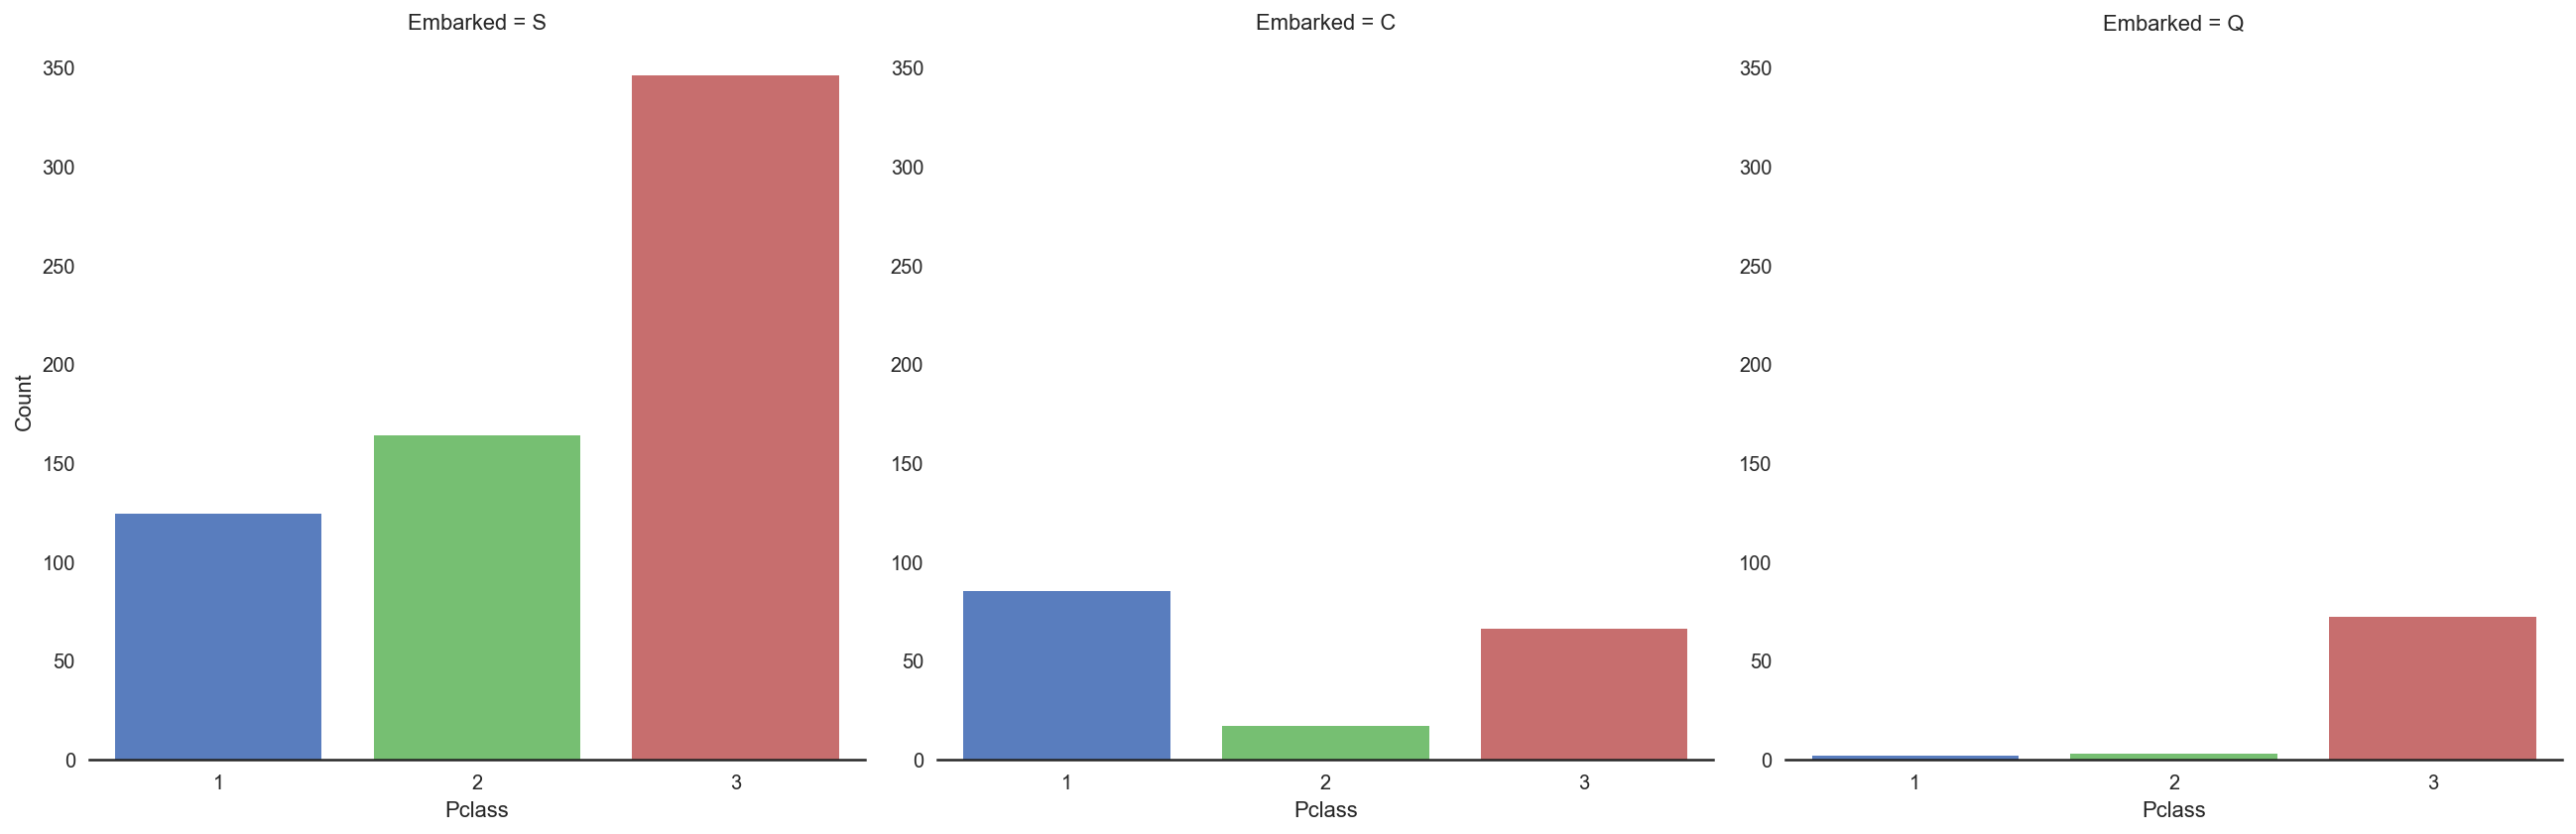

In [31]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Comments :

    - Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

    - I think that first class passengers were prioritised during the evacuation.

## 4. Filling missing Values
### 4.1 Age

In [32]:
all_data["Age"].isnull().sum()

256

Note :

    - As we see, Age column contains 256 missing values in the whole dataset.

    - Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values. 

    - To adress this problem, I looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

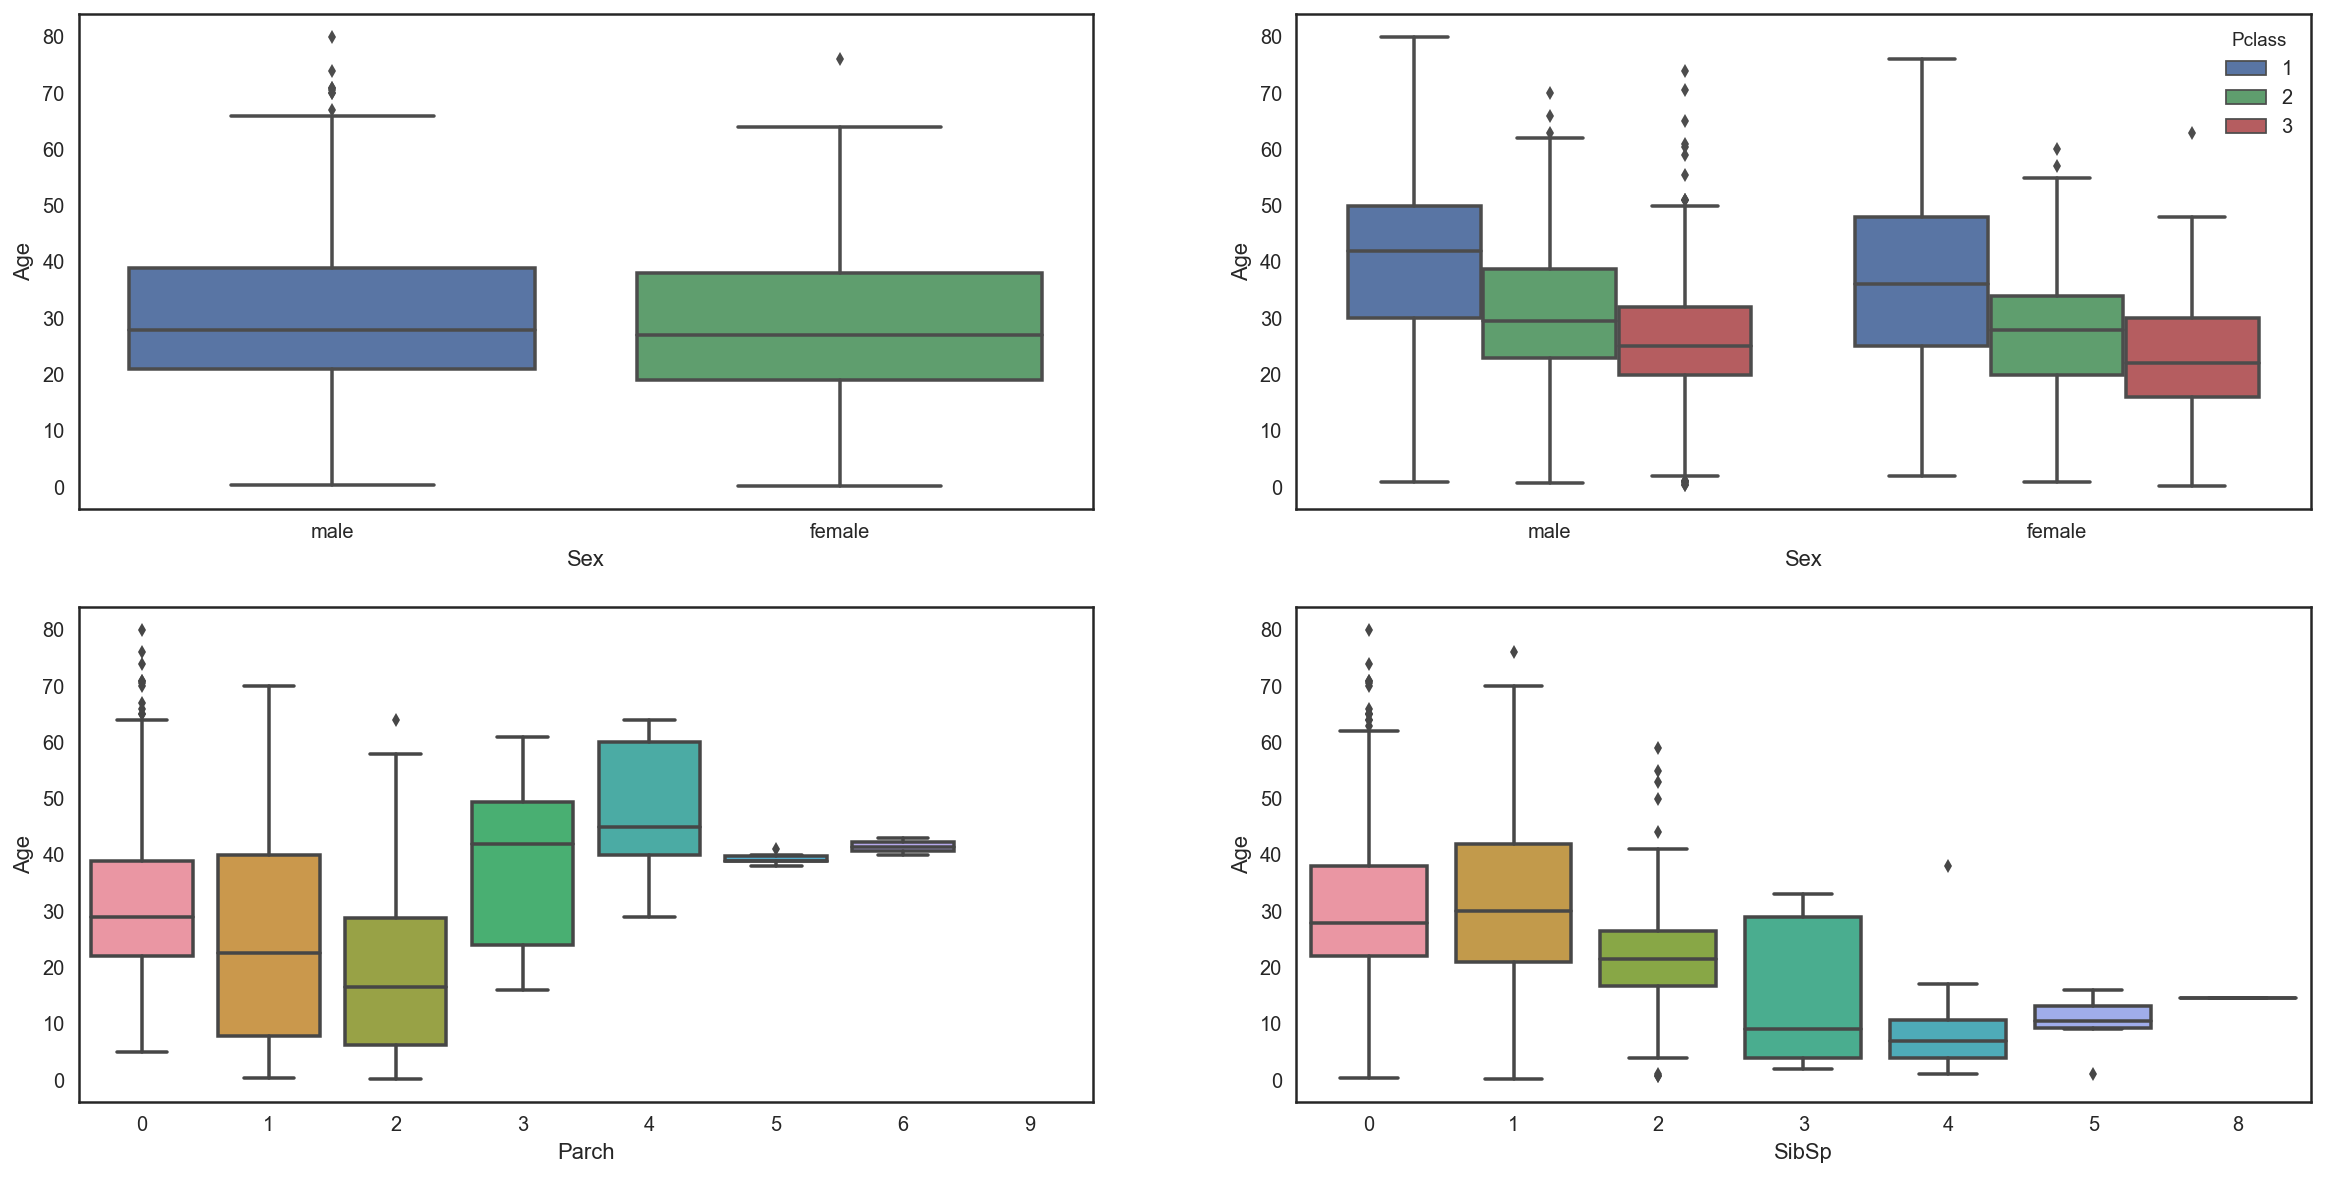

In [33]:
# Explore Age vs Sex, Parch , Pclass and SibSP
plt.figure(figsize=(20,10))

ax1 = plt.subplot(2,2,1)
sns.boxplot(y="Age",x="Sex",data=all_data, ax=ax1)

ax2 = plt.subplot(2,2,2)
sns.boxplot(y="Age",x="Sex",hue="Pclass", data=all_data, ax=ax2)

ax3 = plt.subplot(2,2,3)
sns.boxplot(y="Age",x="Parch", data=all_data, ax=ax3)

ax4 = plt.subplot(2,2,4)
sns.boxplot(y="Age",x="SibSp", data=all_data, ax=ax4)

plt.show()

Comments :

    - Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

    - However, 1st class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

    - Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.
    

In [34]:
# convert Sex into categorical value 0 for male and 1 for female
all_data["Sex"] = all_data["Sex"].map({"male": 0, "female":1})

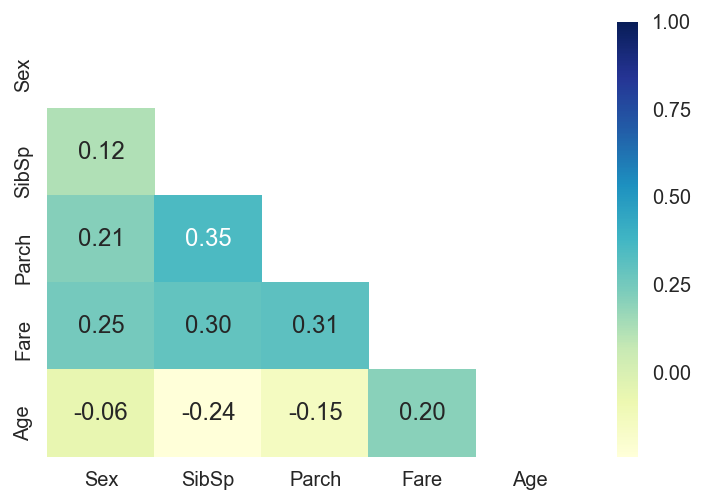

In [35]:
numeric = ["Sex","SibSp","Parch","Pclass","Fare","Age"]
corr = all_data[numeric].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask = mask, annot=True, fmt = ".2f", cmap = "YlGnBu")

Comments :

     - The correlation map confirms that Age is negatively correlated with Pclass and SibSp.

     - I decided to use SibSP and Pclass in order to impute the missing ages.

     - My plan is to fill Age with the median age of similar rows according to Pclass and SibSp.

In [36]:
# fill Age with the median age of similar rows according to Pclass and SibSp

age_nan = list(all_data["Age"][all_data["Age"].isnull()].index)

for i in age_nan:
    age_median = all_data["Age"].median()
    age_pred = all_data["Age"][((all_data['SibSp'] == all_data.iloc[i]['SibSp']) & (all_data['Pclass'] == all_data.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        all_data['Age'].iloc[i] = age_pred
    else :
        all_data['Age'].iloc[i] = age_median

## 5. Feature engineering
### 5.1 Name/Title

In [37]:
all_data["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Notes :

    - The Name feature contains information on passenger's title.

    - Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.

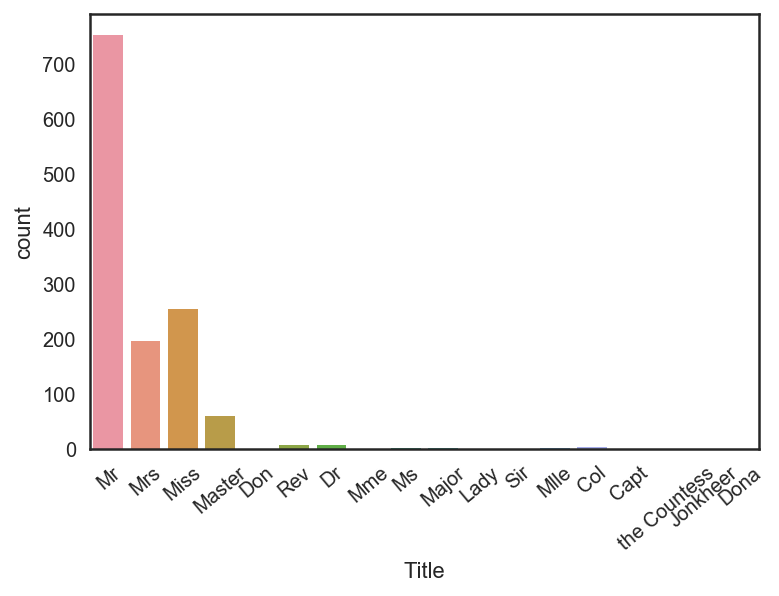

In [38]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in all_data["Name"]]
all_data["Title"] = pd.Series(dataset_title)

g = sns.countplot(x="Title",data=all_data)
g = plt.setp(g.get_xticklabels(), rotation=40) 

Comments :

    - There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [39]:
# Convert to categorical values Title 
all_data["Title"] = all_data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
all_data["Title"] = all_data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
all_data["Title"] = all_data["Title"].astype(int)

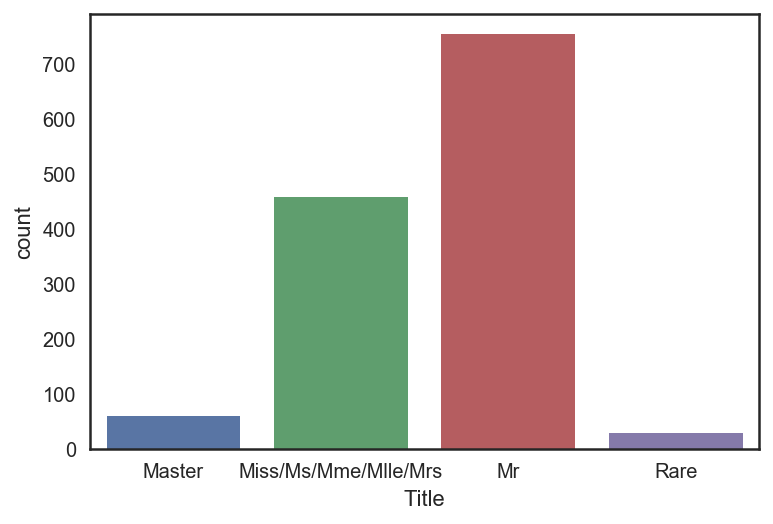

In [40]:
g = sns.countplot(all_data["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

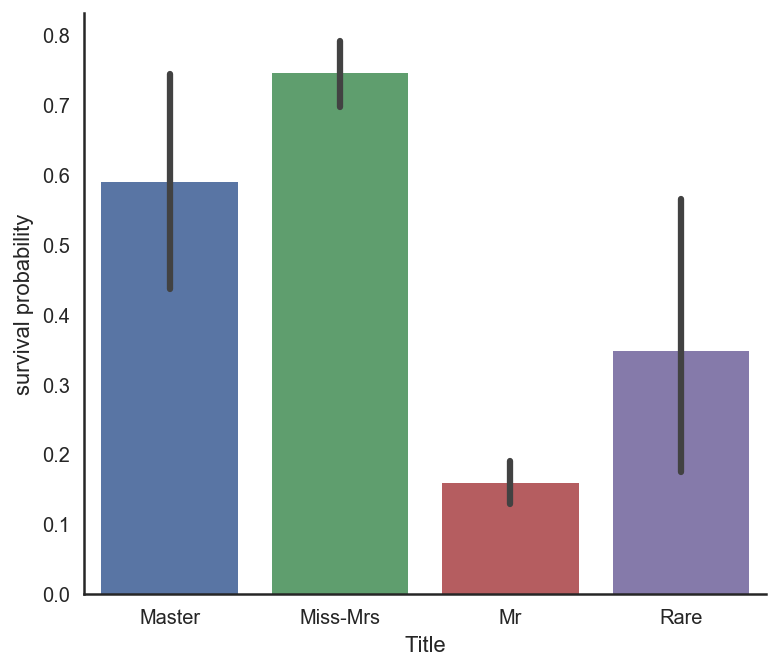

In [41]:
h = sns.factorplot(x="Title",y="Survived",data=all_data,kind="bar")
h.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
h.set_ylabels("survival probability")
h.fig.set_size_inches(6,5)

Commnets :

    - Passengers with Master and rare title have more chance to survive.

In [42]:
# Drop Name variable
all_data.drop(labels = ["Name"], axis = 1, inplace = True)

In [43]:
# convert to indicator values Title 
all_data = pd.get_dummies(all_data, columns = ["Title"], prefix = "Title")

### 5.2 Family size

Notes : We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [44]:
# Create a family size descriptor from SibSp and Parch
all_data["Family_size"] = all_data["SibSp"] + all_data["Parch"] + 1

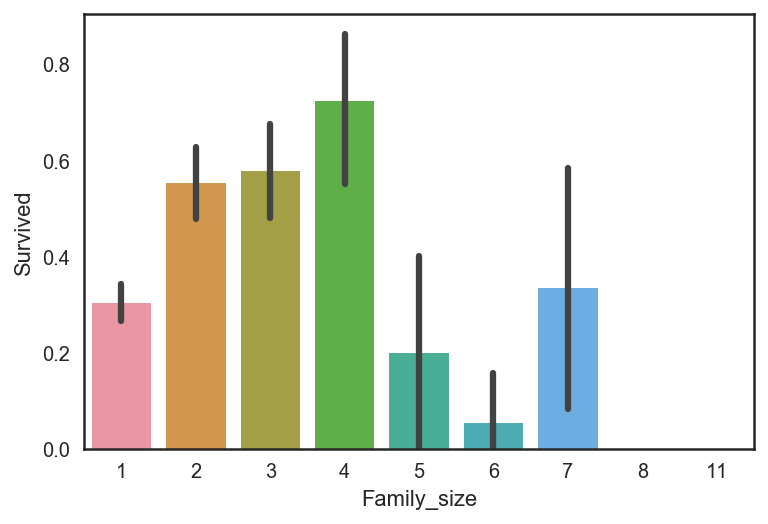

In [45]:
g = sns.barplot(x="Family_size",y="Survived",data = all_data)

Comments :

    - The family size seems to play an important role, survival probability is worst for large families.

    - Additionally, i decided to created 4 categories of family size.

In [46]:
# Create new feature of family size
all_data['Single'] = all_data['Family_size'].map(lambda s: 1 if s == 1 else 0)
all_data['Small_F'] = all_data['Family_size'].map(lambda s: 1 if  s == 2  else 0)
all_data['Med_F'] = all_data['Family_size'].map(lambda s: 1 if 3 <= s <= 4 else 0)
all_data['Large_F'] = all_data['Family_size'].map(lambda s: 1 if s >= 5 else 0)

# Drop Family_size variable
all_data.drop(labels = ["Family_size"], axis = 1, inplace = True)

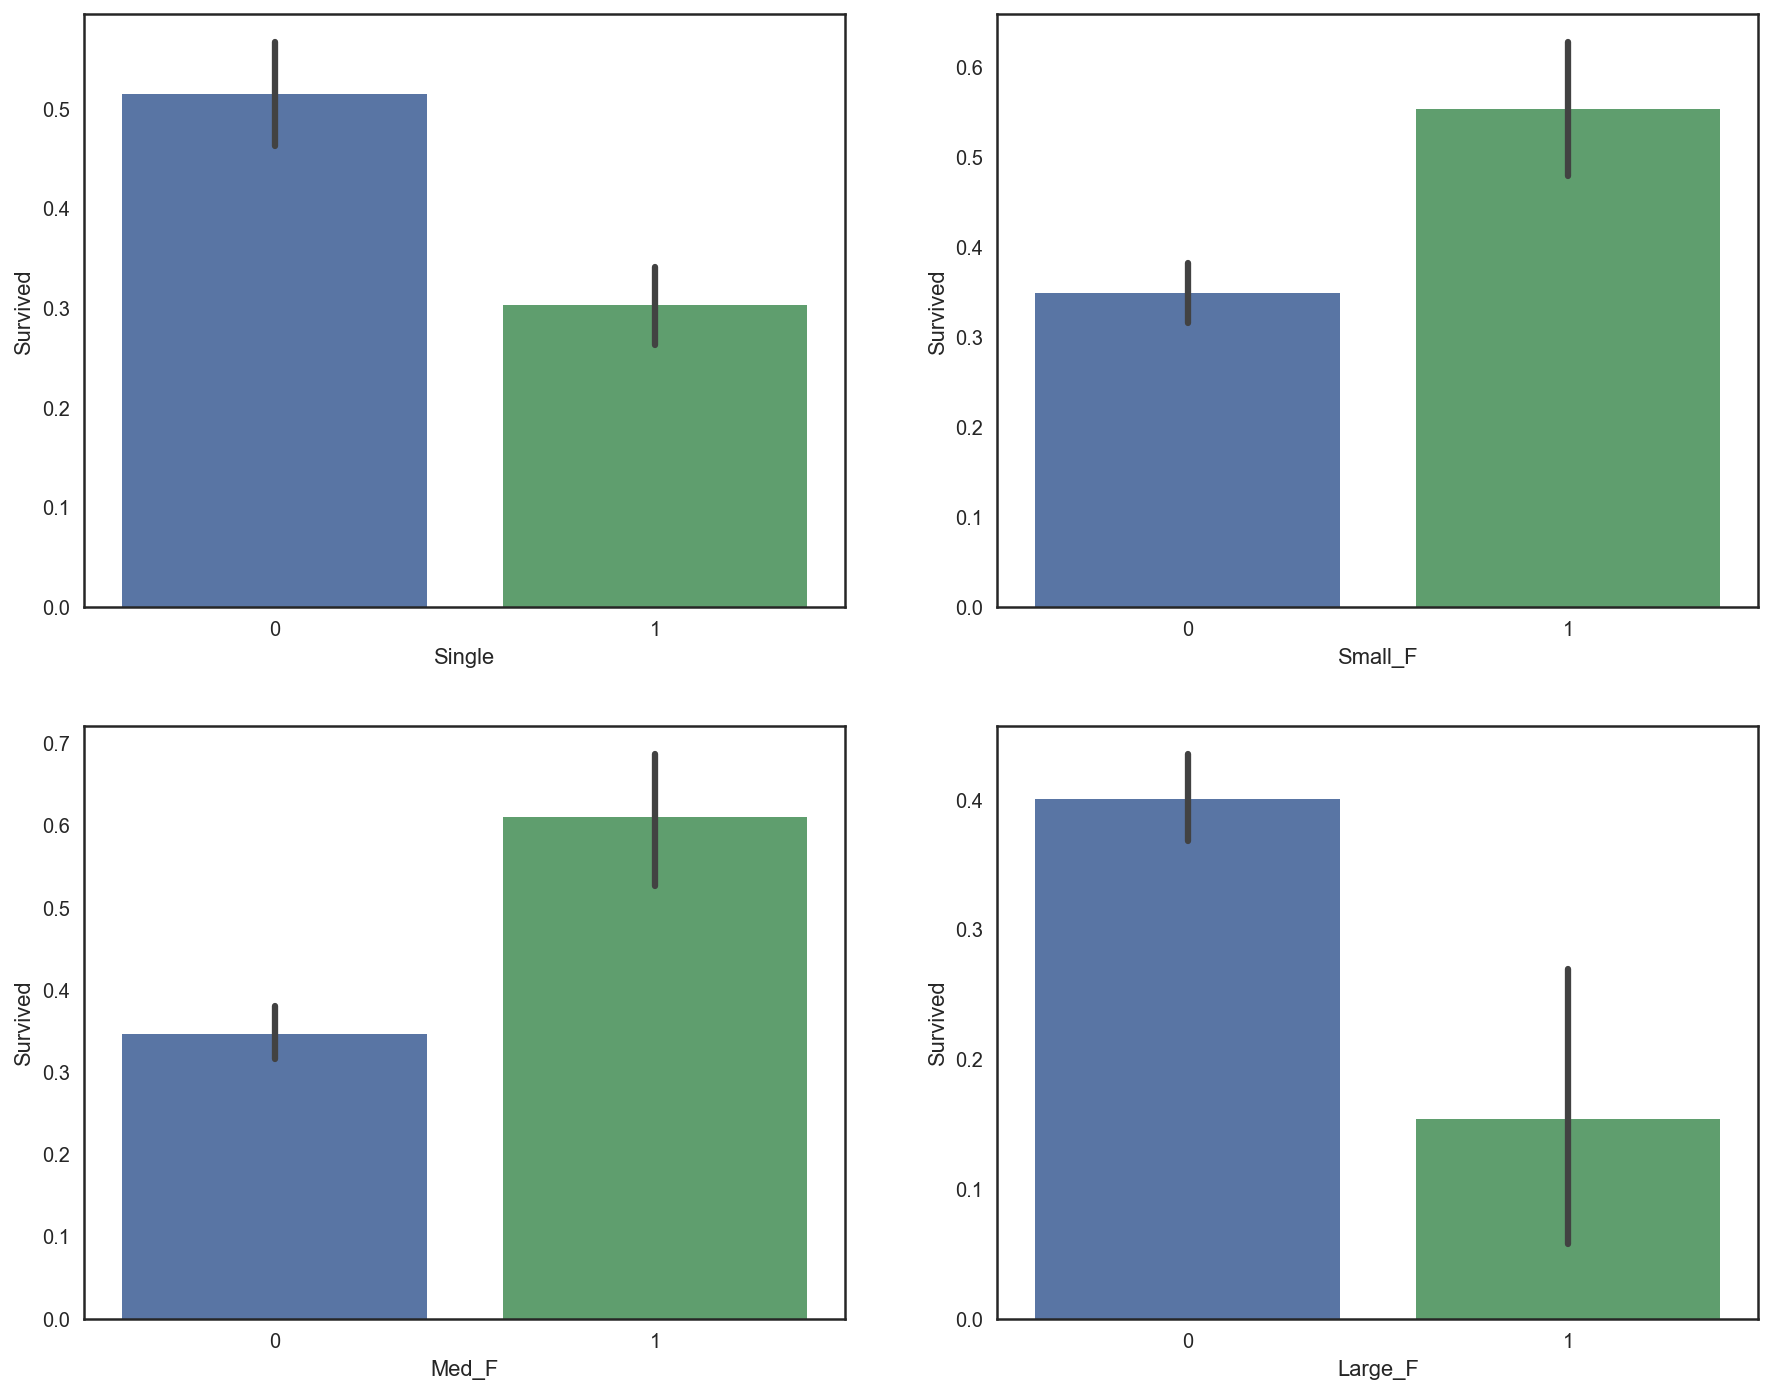

In [47]:
plt.figure(figsize=(15,12))

ax1 = plt.subplot(2,2,1)
sns.barplot(x="Single",y="Survived",data=all_data,ax=ax1)

ax2 = plt.subplot(2,2,2)
sns.barplot(x="Small_F",y="Survived",data=all_data,ax=ax2)

ax3 = plt.subplot(2,2,3)
sns.barplot(x="Med_F",y="Survived",data=all_data,ax=ax3)

ax4 = plt.subplot(2,2,4)
sns.barplot(x="Large_F",y="Survived",data=all_data,ax=ax4)

plt.show()

Commnets :

    - Barplots of categories show that Small and Medium families have more chance to survive than single passenger and large families.

### 5.3 Cabin

In [48]:
all_data["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
all_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2', 'C2',
       'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31', 'D36',
       'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94', 'C125',
       'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106', 'C65',
       'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124',
       'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98',
       'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111', 'C92', 'E38',
       'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20', 'B79', 'E25',
       'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16',
       'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9',
       'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71', 'B51 B53 B55',
       'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [50]:
all_data['Cabin'].isnull().sum()

1007

Notes :

    - The Cabin feature column contains 1007 missing values.

    - I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [51]:
all_data["Cabin"][all_data["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# Replace the Cabin number by the type of cabin 'X' if not
all_data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in all_data['Cabin'] ])

Comments : 

    - I think the Cabin's letter indicates the probable location of the passenger in the Titanic

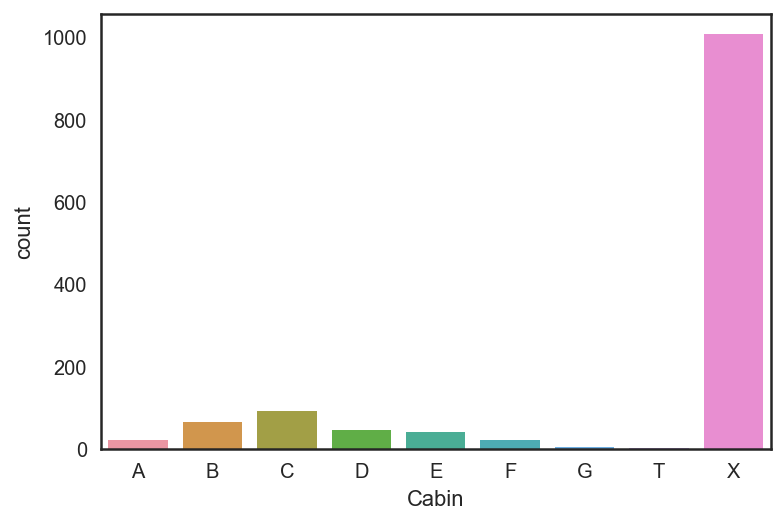

In [53]:
g = sns.countplot(all_data["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

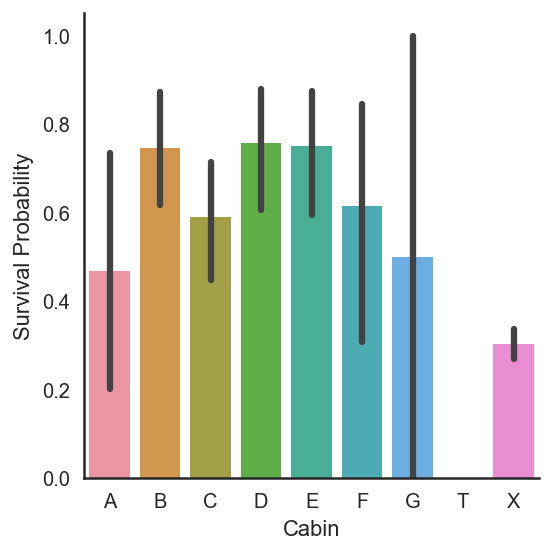

In [54]:
g = sns.factorplot(y="Survived",x="Cabin",data=all_data,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

Comments :

    - We can see that passengers with a cabin have generally more chance to survive than passengers without (X).


In [55]:
# convert to indicator values Cabin 
all_data = pd.get_dummies(all_data, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [56]:
all_data["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Notes :

    - It could mean that tickets sharing the same prefixes could be booked for cabins placed together. It could therefore lead to the actual placement of the cabins within the ship.

    - Tickets with same prefixes may have a similar class and survival.

    - So i decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.

In [57]:
Ticket = []

for i in list(all_data.Ticket):
    if not i.isdigit():
        #Take prefix
        Ticket.append(i.replace(".", "").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append('X')
                      
all_data['Ticket'] = Ticket
all_data['Ticket'].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
all_data = pd.get_dummies(all_data, columns = ["Ticket"], prefix="Ticket")
all_data = pd.get_dummies(all_data, columns = ["Pclass"],prefix="Pclass")
all_data = pd.get_dummies(all_data, columns = ["Embarked"],prefix="Embarked")

# Drop useless variables 
all_data.drop(labels = ["PassengerId"], axis = 1, inplace = True)

In [59]:
numerical_features = []
categorical_features = []
for f in all_data.columns:
    if all_data.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [60]:
categorical_features

[]

## 6. Modeling

### 6-1 Prepare input & test Data for Modeling

In [61]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [62]:
all_data = all_data.drop(labels=["Ticket_SCA3", "Ticket_STONOQ", "Ticket_AQ4", "Ticket_AQ3", "Ticket_A", "Ticket_LP"], axis=1)

In [69]:
from sklearn.preprocessing import MinMaxScaler

def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data


def normalize_fare(data):
    scaler = MinMaxScaler()
    data["Fare"] = scaler.fit_transform(data["Fare"].values.reshape(-1,1))
    return data

all_data = normalize_age(all_data)
all_data = normalize_fare(all_data)

In [70]:
# Separate train dataset and test dataset
train = all_data[:train_len]
X_test = all_data[train_len:]
X_test.drop(labels=["Survived"],axis = 1,inplace=True)

In [71]:
# Separate train features and label 
train["Survived"] = train["Survived"].astype(int)
y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis = 1)
# X_train = sm.add_constant(X_train_0)

In [80]:
logit_mod = sm.Logit(y_train, X_train)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  881
Model:                          Logit   Df Residuals:                      827
Method:                           MLE   Df Model:                           53
Date:                Thu, 22 Mar 2018   Pseudo R-squ.:                  0.4473
Time:                        17:16:50   Log-Likelihood:                -324.76
converged:                      False   LL-Null:                       -587.53
                                        LLR p-value:                 5.316e-79
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age               -1.9042      0.793     -2.401      0.016      -3.459      -0.349
Fare               3.6017      1.414      2.548      0.011       0.831       6.372
Parch              0.2234      0.415

/Users/sunghwanki/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [81]:
predTest_l = logit_res.predict(X_test)

In [86]:
predTest_ll = np.array(predTest_l)

In [85]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(0.5)

In [89]:
predTest_ll = predTest_ll[:,np.newaxis]

In [90]:
predTest_b = binarizer.fit_transform(predTest_ll)

In [91]:
predTest = predTest_b.astype(np.int32)
predTest[:10]

array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0]], dtype=int32)

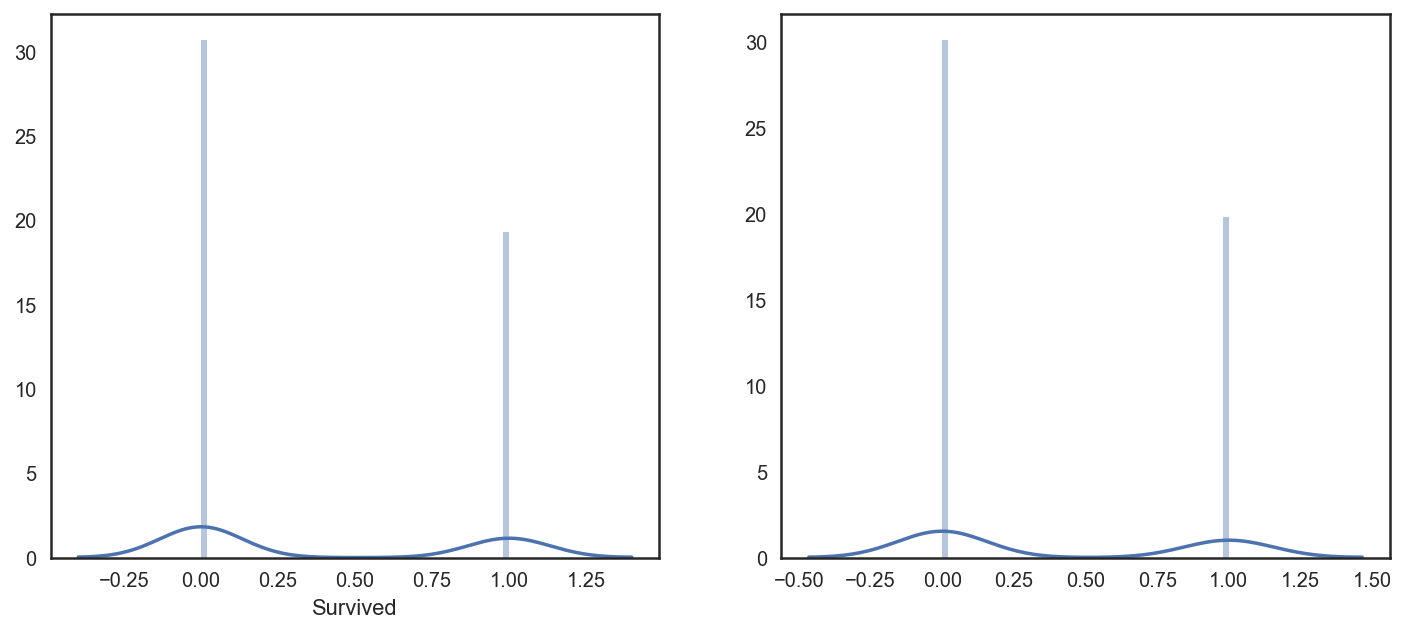

In [92]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(predTest,ax=ax2,bins=50)

In [93]:
submission = pd.read_csv("../2_Titanic_Machine_Learning_from_Disaster/Submit/gender_submission.csv")
submission

submission["Survived"] = predTest


print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [95]:
#csv 파일형식으로 출력
submission.to_csv("../2_Titanic_Machine_Learning_from_Disaster/Submit/logistics_submission_2.csv", index=False)

score: 0.75119  8883/10,435 [85%]